<a href="https://colab.research.google.com/github/tmgrgg/nlp-mafiascum/blob/master/CNN_Mafiascum_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Motivation: 

Users are more likely to lie multiple times in a single document. Therefore to learn a lying signal in a deep learning system.. it's better to target locally and then aggregate.

this notebook now has reproducibility!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Build Dataset

In [2]:
import pandas as pd
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

#SEED = 49
#pretty good 

SEED = 49
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

DOCS_PATH = 'drive/My Drive/MAFIA_DATA/24h_of_deception_basic.pkl'

docs = pd.read_pickle(DOCS_PATH)
docs = docs.sample(frac=1)

print(len(docs))

TEST_RATIO = 0.5
VALID_RATIO = 0.3

# split at user level to stop leakage (plus, we want to be agnostic to author identity!)
users = docs.author.unique()
np.random.shuffle(users)

train_users = users[int(len(users)*TEST_RATIO):]
test_users = users[:int(len(users)*TEST_RATIO)]
valid_users = train_users[:int(len(train_users)*VALID_RATIO)]
train_users = train_users[int(len(train_users)*VALID_RATIO):]

train_docs = docs[np.isin(docs['author'].values, train_users)]
valid_docs = docs[np.isin(docs['author'].values, valid_users)]
test_docs = docs[np.isin(docs['author'].values, test_users)]

print(docs.iloc[0]['author'] == 'Egg')
print(docs.iloc[1]['author'] == 'Wake88')
print(train_docs.iloc[0]['author'] == 'Egg')
print(train_docs.iloc[1]['author'] == 'Vendagoat')
print(valid_docs.iloc[0]['author'] == 'Wake88')
print(valid_docs.iloc[1]['author'] == 'OhGodMyLife')
print(test_docs.iloc[0]['author'] == 'Bellaphant')
print(test_docs.iloc[1]['author'] == 'Fishbulb')

print(len(train_docs[train_docs['scum'] == False])/len(train_docs))
print(len(valid_docs[valid_docs['scum'] == False])/len(valid_docs))
print(len(test_docs[test_docs['scum'] == False])/len(test_docs))

112523
False
False
False
False
False
False
False
False
0.7640725776093558
0.76381299332119
0.7598832864818703


In [0]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field), ('index', Field(sequential=False, use_vocab=False))]
        examples = []
        for i, row in df.iterrows():
            label = row.scum 
            text = row.words
            examples.append(data.Example.fromlist([text, label, i], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

from torchtext.data import Field, LabelField

# define Fields
TEXT = Field(sequential=True, include_lengths=True, batch_first=True)
LABEL = LabelField(dtype=torch.float)
#LABEL = LabelField(dtype=torch.long)

# define Dataset
#train_data = 
#dataset = DataFrameDataset(docs, TEXT, LABEL)
train_data = DataFrameDataset(train_docs, TEXT, LABEL)
valid_data = DataFrameDataset(valid_docs, TEXT, LABEL)
test_data = DataFrameDataset(test_docs, TEXT, LABEL)

#train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))
#train_data, valid_data = train_data.split(split_ratio = 0.8, random_state= random.seed(SEED))

False
False
False
False
False
False
39847
16470
56206


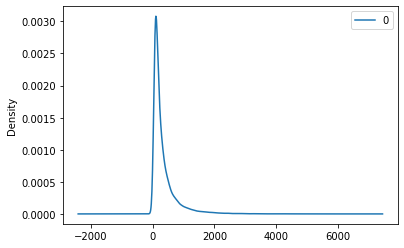

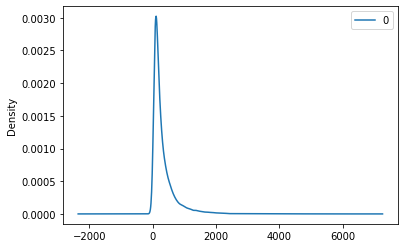

In [4]:
# data split analysis...
train_lens = []
test_lens = []
valid_lens = []
for x in train_data:
  train_lens.append(len(x.text))

for x in test_data:
  test_lens.append(len(x.text))

for x in valid_data:
  valid_lens.append(len(x.text))

print(train_lens[0] == 384)
print(train_lens[1] == 110)

print(valid_lens[0] == 766)
print(valid_lens[1] == 500)

print(test_lens[0] == 159)
print(test_lens[1] == 171)

print(len(train_data))
print(len(valid_data))
print(len(test_data))

import pandas as pd
train_df = pd.DataFrame(train_lens)
test_df = pd.DataFrame(test_lens)
valid_df = pd.DataFrame(valid_lens)
train_df.plot.kde()
valid_df.plot.kde()

# Specify Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, 256)
        self.fc2 = nn.Linear(256, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        #return self.fc(cat)
        return self.fc2(F.relu(self.fc(cat)))

# TRAINING 

## Training Utilities

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train(model, iterator, optimizer, criterion, weight_by_length=False):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    all_predictions = []
    all_y_true = []
    
    for batch in iterator:       
        optimizer.zero_grad()
        
        text, text_lengths = batch.text

        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)

        if weight_by_length:
          sample_weight = torch.log(text_lengths.float())
          #print(sample_weight)
          loss = sample_weight * loss

        loss = loss.mean()
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions.append(predictions.cpu().detach().numpy())
        all_y_true.append(batch.label.cpu().detach().numpy())

    
    all_y_true = np.hstack(all_y_true)
    all_predictions = np.hstack(all_predictions)
    auc_score = roc_auc_score(all_y_true, all_predictions)   
    ap_score = average_precision_score(all_y_true, all_predictions) 
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), auc_score, ap_score

In [0]:
def evaluate(model, iterator, criterion, weight_by_length=False):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        all_predictions = []
        all_y_true = []
    
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, batch.label)

            if weight_by_length:
              sample_weight = torch.log(text_lengths.float())
              #print(sample_weight)
              loss = sample_weight * loss

            loss = loss.mean()
                
            acc = binary_accuracy(predictions, batch.label)

            all_predictions.append(predictions.cpu().numpy())
            all_y_true.append(batch.label.cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    all_y_true = np.hstack(all_y_true)
    all_predictions = np.hstack(all_predictions)
    auc_score = roc_auc_score(all_y_true, all_predictions)   
    ap_score = average_precision_score(all_y_true, all_predictions)  
    return epoch_loss / len(iterator), epoch_acc / len(iterator), auc_score, ap_score

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import OrderedDict

class StatsTracker():
  def __init__(self, plot_freq=5):
    self.counter = 0
    self.plot_freq = plot_freq
    self._metrics = OrderedDict({})

  def _make_plot(self):
      fig, ax = plt.subplots(1, len(self._metrics.keys()), squeeze=False, figsize=(18,4))
      for i, metric in enumerate(self._metrics.keys()):
        train_metric = self._metrics[metric]['train']
        valid_metric = self._metrics[metric]['valid']
        ax[0, i].plot(list(range(len(train_metric))), train_metric, c='b', label='Train', marker='.')
        ax[0, i].plot(list(range(len(valid_metric))), valid_metric, c='r', label='Valid', marker='.')
        ax[0, i].set_ylabel(metric)
        ax[0, i].set_xlabel('epochs')
        ax[0, i].legend(loc='upper right')

  def plot(self):
    # will plot the current loss_graph every plot_freq^th call to plot
    self.counter += 1
    print('eyo')
    print(self.counter)
    print(self.counter % self.plot_freq)
    if (self.counter % self.plot_freq == 0):
      print('hey')
      fig = self._make_plot()
      clear_output()
      plt.show()
      #fig.close()

  def save(self, path):
    # save the current loss_graph to the given path
    self._make_plot()
    plt.savefig(path)
    plt.close()

  def log(self, value, metric, setting='train'):
    assert(setting == 'train' or setting == 'valid')
    if metric not in self._metrics.keys():
      self._metrics[metric] = {'train': [], 'valid': []}
    self._metrics[metric][setting].append(value)

## Define Model Parameters and Training Hyperparameters

In [0]:
MAX_VOCAB_SIZE = 25000
EMBEDDING_NAME = "glove.6B.100d"

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [0]:
BATCH_SIZE = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(train_data, train=True, sort=True, batch_size = BATCH_SIZE, device = device)
valid_iterator = data.BucketIterator(valid_data, train=False, sort=True, batch_size = BATCH_SIZE, device = device)

51 False
53 False
54 False
59 False


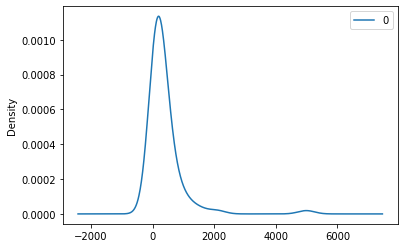

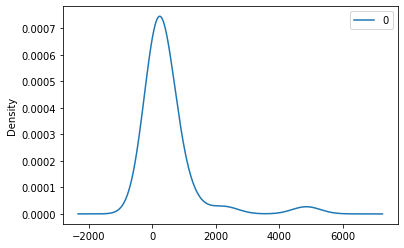

In [13]:
train_lens = []
valid_lens = []

for batch in train_iterator:
  train_lens.append(batch.text[0].shape[1])

for batch in valid_iterator:
  valid_lens.append(batch.text[0].shape[1])

import pandas as pd
train_df = pd.DataFrame(train_lens)
valid_df = pd.DataFrame(valid_lens)

train_df.plot.kde()
valid_df.plot.kde()

print(train_lens[0], train_lens[0] == 3256)
print(train_lens[1], train_lens[1] == 2253)
print(valid_lens[0], valid_lens[0] == 2996)
print(valid_lens[1], valid_lens[1] == 2834)

In [14]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = TEXT.vocab.vectors.shape[1]
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

USE_GLOROT = True
# intialisation
for m in model.modules():
  if(isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear)):
    print('yeppers')
    m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu')) 

yeppers
yeppers
yeppers
yeppers
yeppers
yeppers


In [15]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.00025, weight_decay=0.1)

pos_weight = len(docs[docs['scum'] == False])/len(docs[docs['scum'] == True])
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]), reduction='none')
print('positive weight:', pos_weight)

model = model.to(device)
criterion = criterion.to(device)

positive weight: 3.2006570351289803


## Training Loop

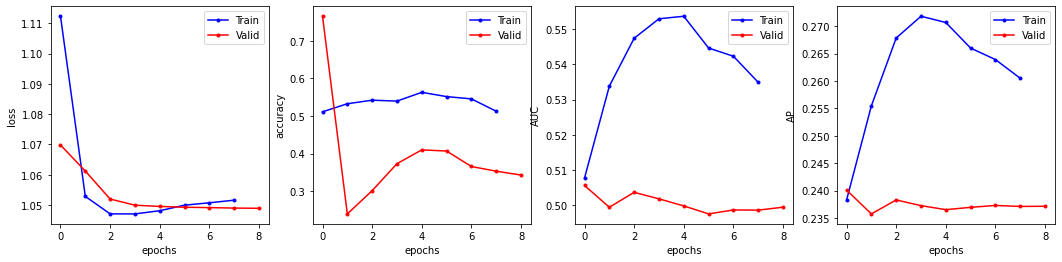

Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 1.052 | Train Acc: 51.27% | Train AUC: 0.535 | Train AP: 0.260
	 Val. Loss: 1.049 |  Val. Acc: 34.29% | Val. AUC: 0.499 | Val. AP: 0.237


In [0]:
N_EPOCHS = 30
WEIGHT_BY_LENGTH = False
best_valid_loss = float('inf')
tracker = StatsTracker(plot_freq=1)
valid_loss, valid_acc, valid_auc, valid_ap = evaluate(model, valid_iterator, criterion, weight_by_length=WEIGHT_BY_LENGTH)
tracker.log(valid_loss, 'loss', setting='valid')
tracker.log(valid_acc, 'accuracy', setting='valid')
tracker.log(valid_auc, 'AUC', setting='valid')
tracker.log(valid_ap, 'AP', setting='valid')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_auc, train_ap = train(model, train_iterator, optimizer, criterion, weight_by_length=WEIGHT_BY_LENGTH)
    valid_loss, valid_acc, valid_auc, valid_ap = evaluate(model, valid_iterator, criterion, weight_by_length=WEIGHT_BY_LENGTH)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    tracker.log(train_loss, 'loss', setting='train')
    tracker.log(valid_loss, 'loss', setting='valid')
    tracker.log(train_acc, 'accuracy', setting='train')
    tracker.log(valid_acc, 'accuracy', setting='valid')
    tracker.log(train_auc, 'AUC', setting='train')
    tracker.log(valid_auc, 'AUC', setting='valid')
    tracker.log(train_ap, 'AP', setting='train')
    tracker.log(valid_ap, 'AP', setting='valid')
    tracker.plot()

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train AUC: {train_auc:.3f} | Train AP: {train_ap:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. AUC: {valid_auc:.3f} | Val. AP: {valid_ap:.3f}')

# write results for future reference ;)
save_path = 'drive/My Drive/model:N_FILTERS[{}]_FILTER_SIZES[{}]_DROPOUT[{}]_VOCAB_SIZE[{}]_EMBED[{}]_OPTIM[{}]_WEIGHT_BY_LENGTH[{}]'.format(
    str(N_FILTERS),
    str(FILTER_SIZES),
    DROPOUT,
    MAX_VOCAB_SIZE,
    EMBEDDING_NAME,
    '_'.join(str(optimizer).split('\n')),
    WEIGHT_BY_LENGTH
)

tracker.save(save_path + '.png')
    

In [0]:
 torch.save(model.state_dict(), 'final-model.pt')

In [0]:
test_iterator = data.BucketIterator(test_data, batch_size = BATCH_SIZE, device = device)

In [0]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
best_model.load_state_dict(torch.load('best-model.pt'))
best_model = best_model.to(device)

test_loss, test_acc, test_auc, test_ap = evaluate(best_model, test_iterator, criterion)

print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}% | Test. AUC: {test_auc:.3f} | Test. AP: {test_ap:.3f}')


In [0]:
FINAL_DOCS_PATH = 'drive/My Drive/MAFIA_DATA/full_10000_docs.pkl'

final_docs = pd.read_pickle(FINAL_DOCS_PATH)
final_docs = final_docs.sample(frac=1, )

print(len(final_docs))

In [0]:
final_docs